In [2]:
# visualization and database management
import h5py
import os
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
from sklearn.utils import shuffle

# Machine learning
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import scale

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#auto load external code.
%load_ext autoreload  
%autoreload 2

/Users/trongnguyen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# set large font for presentation
sns.set_context("poster", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20}) 
import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
sns.set_style('darkgrid')

In [4]:
os.chdir('/Users/trongnguyen/Dropbox/FattyLiver/src/hydrogen/')
from helper_brl.visualizeHelper import extract_segment_points, envDetection, filter_frame
from helper_brl.fattyLiver import get_training_data, get_testing_data, \
choose_testing_rabbits_indices, get_training_test_data_frame
from helper_brl.outlierDetection import getBSC_Att, filter_bsc, \
filter_BSC_based_on_depth, findOutliers
from helper_brl import frequencyAnalysis
from helper_brl.formFactor import get_ESD_EAC, gaussian_form_factor_bsc, \
exponential_form_factor_bsc, ESD_EAC_features
from helper_brl.ml_preprocessing import percentageVariance, cal_accuracy, randomize_and_filter

# Load Data

In [6]:
newdataBase = pd.read_excel('/Users/trongnguyen/Dropbox/FattyLiver/Rabbit_Liver_40.xlsx', sheet_name=0)
aliveOnly = newdataBase[newdataBase['Timely death'] == 1]
dataBase = aliveOnly[['Rabbit', 'Injection level', 'Weeks on diet','Lipid']]
dataBase = dataBase[dataBase['Injection level'] ==0]

threshold_lipid = 9
dataBase['High'] = dataBase.Lipid > threshold_lipid
dataBase = dataBase.sort_values(['Lipid'])
dataBase.index = range(1, 16)
dataBase['Labels'] = dataBase['High'].apply(lambda x: 'High lipid' if x else 'Low lipid')

In [6]:
%qtconsole

In [7]:
dataBase['Labels'] = dataBase['High'].apply(lambda x: 'High fat' if x else 'Low fat')

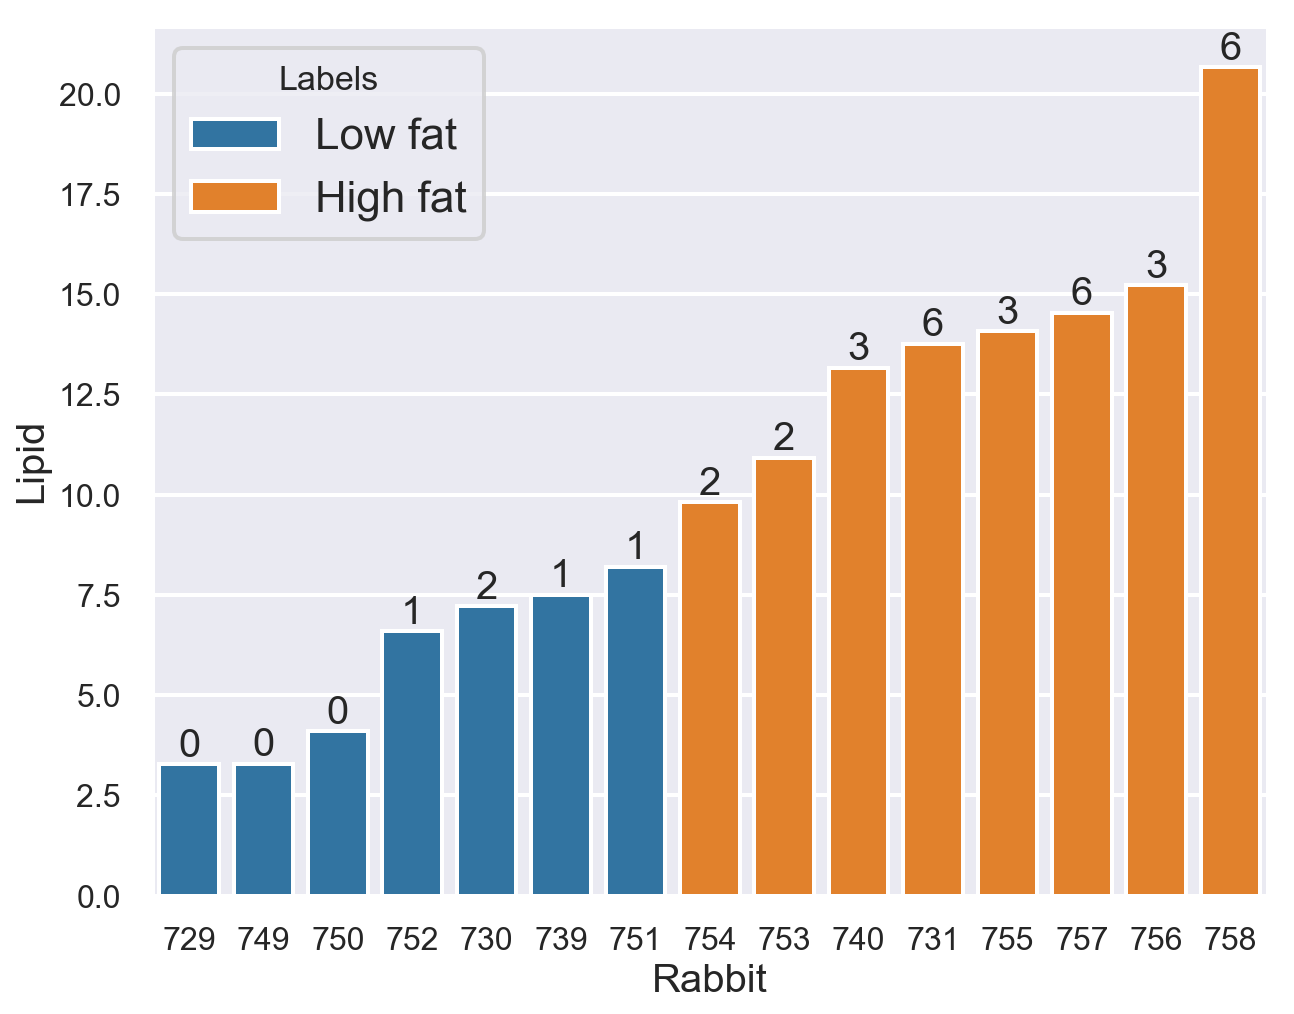

In [8]:
plt.figure(figsize = (10, 8))
ax = sns.barplot(x = 'Rabbit', y = 'Lipid', data = dataBase, hue = 'Labels', \
                 order=dataBase.Rabbit, dodge = False)
count = 1
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):
        continue
    no_weeks = dataBase['Weeks on diet'][count]
    count = count + 1
    plt.text(p.get_x()+p.get_width()/2.,
            height + 0.2,
            int(no_weeks),
            ha="center") 

## Input/output data  - Load BSC and ATT

In [9]:
RIGHT_SIDE = ['754', '751', '729']

In [10]:
ATTs_dict, freq_att_dict, freq_bsc_dict, depth_dict, BSCs_dict = {}, {}, {}, {}, {} 
left_dict, right_dict, top_dict, bottom_dict = {}, {}, {}, {} # ROIs of each BSC
att_bottom, bad_BSC = {}, {}

#name_tag = 'fix_bug_average_ref_phantom_6MHz_v7_12a_30b'
name_tag = 'fix_bug_average_ref_phantom_3_6MHz_v8_10a40_30b'
for idx, row in dataBase.iterrows():
    number = str(int(row.Rabbit))
    print(number, end = ', ')
    if number in RIGHT_SIDE:
        path = "/Volumes/TrongDrive/Liver_Study/PostProcessedFiles/L" + number + "/L94_right/BSC_ATT/"
    else:
        path = "/Volumes/TrongDrive/Liver_Study/PostProcessedFiles/L" + number + "/L94_left/BSC_ATT/"
    ATTs_dict[number], freq_att_dict[number], BSCs_dict[number], freq_bsc_dict[number], \
    depth_dict[number], left_dict[number], right_dict[number], \
    top_dict[number], bottom_dict[number], att_bottom[number], bad_BSC[number] = getBSC_Att(path,name_tag)

729, 749, 750, 752, 730, 739, 751, 754, 753, 740, 731, 755, 757, 756, 758, 

In [11]:
rf_hdf5_path = '/Volumes/TrongDrive/Liver_Study/RF_hdf5/'
root_path = '/Volumes/TrongDrive/Liver_Study/PostProcessedFiles/L'

In [14]:
file_path = "/Users/trongnguyen/Downloads/CODE/BatchProcessing/TrongCode/BSC_trong/LO_FREQ_REF_6.20.11.txt"
data = pd.read_csv(file_path, sep="\t", header=None)
data.columns = ['Frequency', 'BSC']

# PCA and Random Forest and CNN stuff

In [33]:
all_idx = dataBase.Rabbit.as_matrix()
no_cv = 15

In [13]:
freq_key = next(iter(freq_bsc_dict['729']))
freq = freq_bsc_dict['729'][freq_key].flatten()
print(freq)

[3.         3.00293255 3.0058651  ... 5.9941349  5.99706745 6.        ]


In [15]:
dataBase['bad Rabbit'] = False

In [16]:
dataBase.loc[dataBase.Rabbit == 729, 'bad Rabbit'] = True

In [17]:
dataBase_filter = dataBase[dataBase['bad Rabbit'] == False]

In [18]:
dataBase_filter

,Rabbit,Injection level,Weeks on diet,Lipid,High,Labels,bad Rabbit
2,749,0,0,3.29,False,Low fat,False
3,750,0,0,4.10,False,Low fat,False
4,752,0,1,6.60,False,Low fat,False
5,730,0,2,7.22,False,Low fat,False
6,739,0,1,7.50,False,Low fat,False
7,751,0,1,8.20,False,Low fat,False
8,754,0,2,9.81,True,High fat,False
9,753,0,2,10.92,True,High fat,False
10,740,0,3,13.17,True,High fat,False
11,731,0,6,13.76,True,High fat,False


# ATT Logistic Regression

In [20]:
from helper_brl.fattyLiver import get_att_features_train_test

In [21]:
from sklearn.linear_model import LogisticRegression

In [24]:
lg_accuracy = np.zeros((15,2))
svm_accuracy = np.zeros((15,2))
#weights_lg = np.zeros((15, 4))
for i in range(no_cv-1):
    #testing_idx = all_idx[i*no_test_rabbits:i*no_test_rabbits+no_test_rabbits]
    testing_idx = [all_idx[i]]
    print(testing_idx, end = ', ')
    
    X_train, y_train = get_att_features_train_test(dataBase_filter, testing_idx, freq, ATTs_dict, training = True)

    X_test, y_test = get_att_features_train_test(dataBase_filter, testing_idx, freq, ATTs_dict, training = False)
    clf_lg = LogisticRegression()
    clf_lg.fit(X_train,y_train)
    
    clf_svm = svm.SVC(C=1.0,kernel='linear', gamma=1)
    clf_svm.fit(X_train, y_train)
  
    y_predict_lg = clf_lg.predict(X_test)
    y_predict_svm = clf_svm.predict(X_test)
    
    lg_accuracy[i, 0] = accuracy_score(y_test, y_predict_lg)
    lg_accuracy[i, 1] = accuracy_score(y_train, clf_lg.predict(X_train))
    
    svm_accuracy[i, 0] = accuracy_score(y_test, y_predict_svm)
    svm_accuracy[i, 1] = accuracy_score(y_train, clf_svm.predict(X_train))

[749], [750], [752], [730], [739], [751], [754], [753], [740], [731], [755], [757], [756], [758], 

In [25]:
print(np.mean(lg_accuracy, axis = 0))
print(np.mean(svm_accuracy, axis = 0))

[0.79552594 0.8388895 ]
[0.78912071 0.83786536]


In [16]:
from mlxtend.plotting import plot_decision_regions

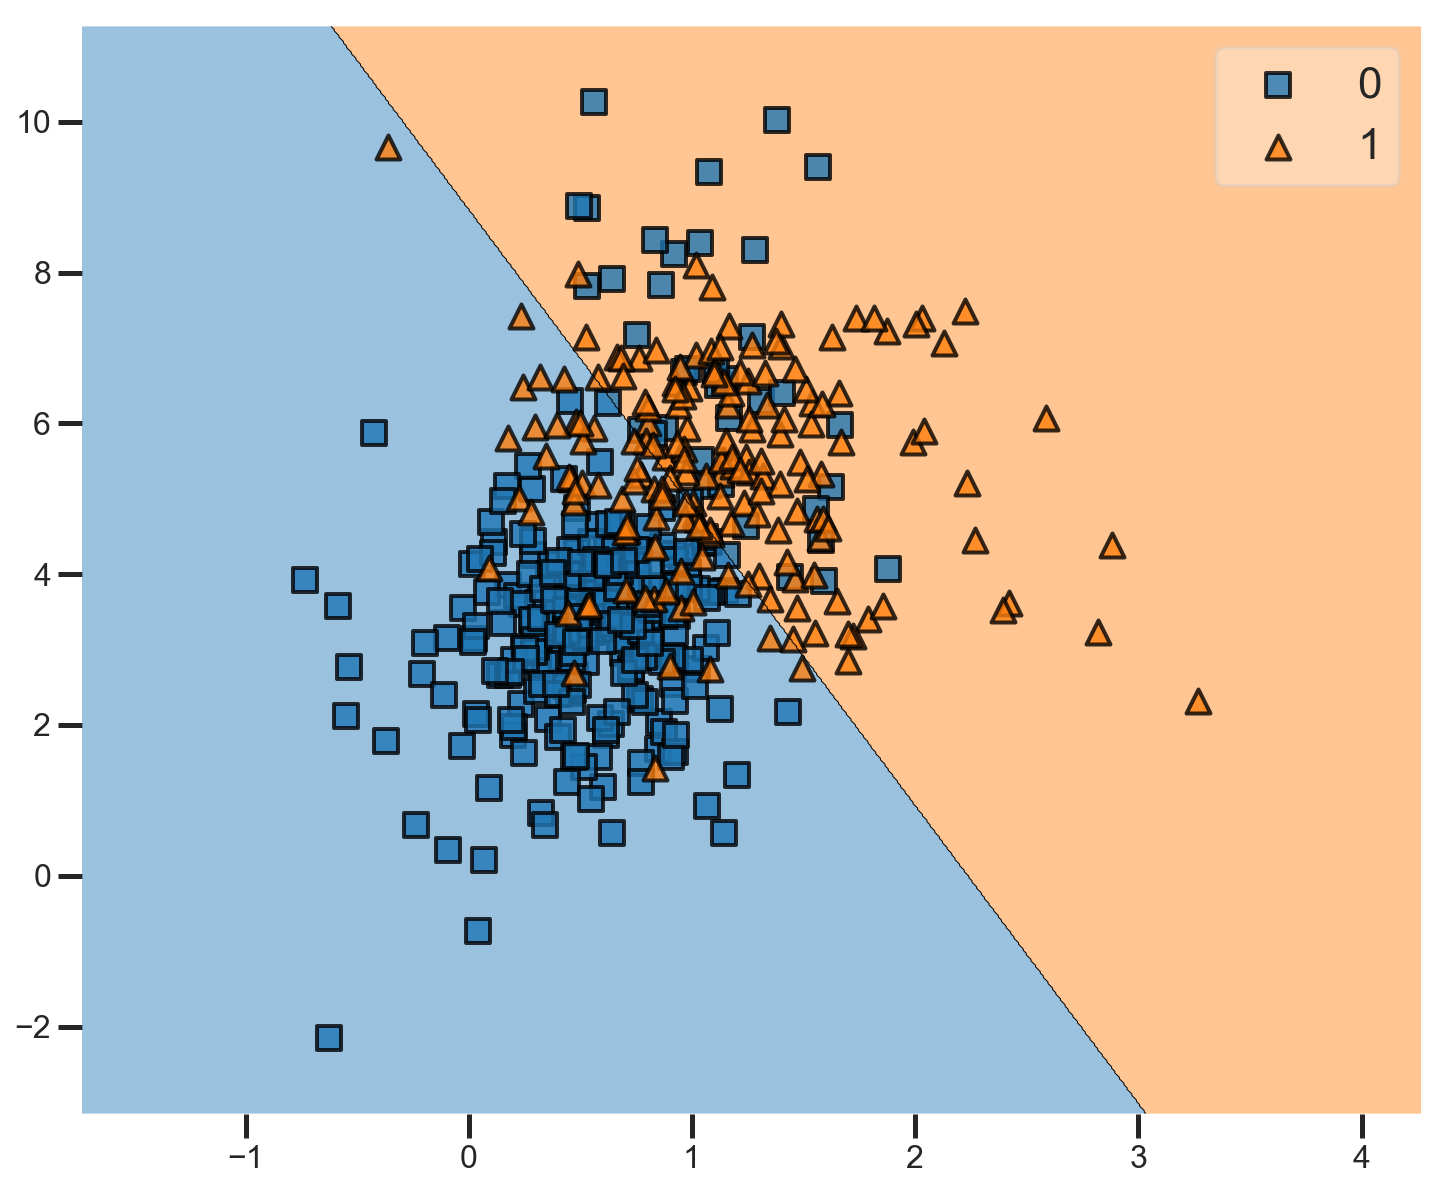

In [17]:
sns.set_style('white')
fig, ax = plt.subplots(1, 1, figsize = (12, 10))
plot_decision_regions(X = X_train, y = y_train.astype(np.integer), clf = clf_lg, ax = ax)

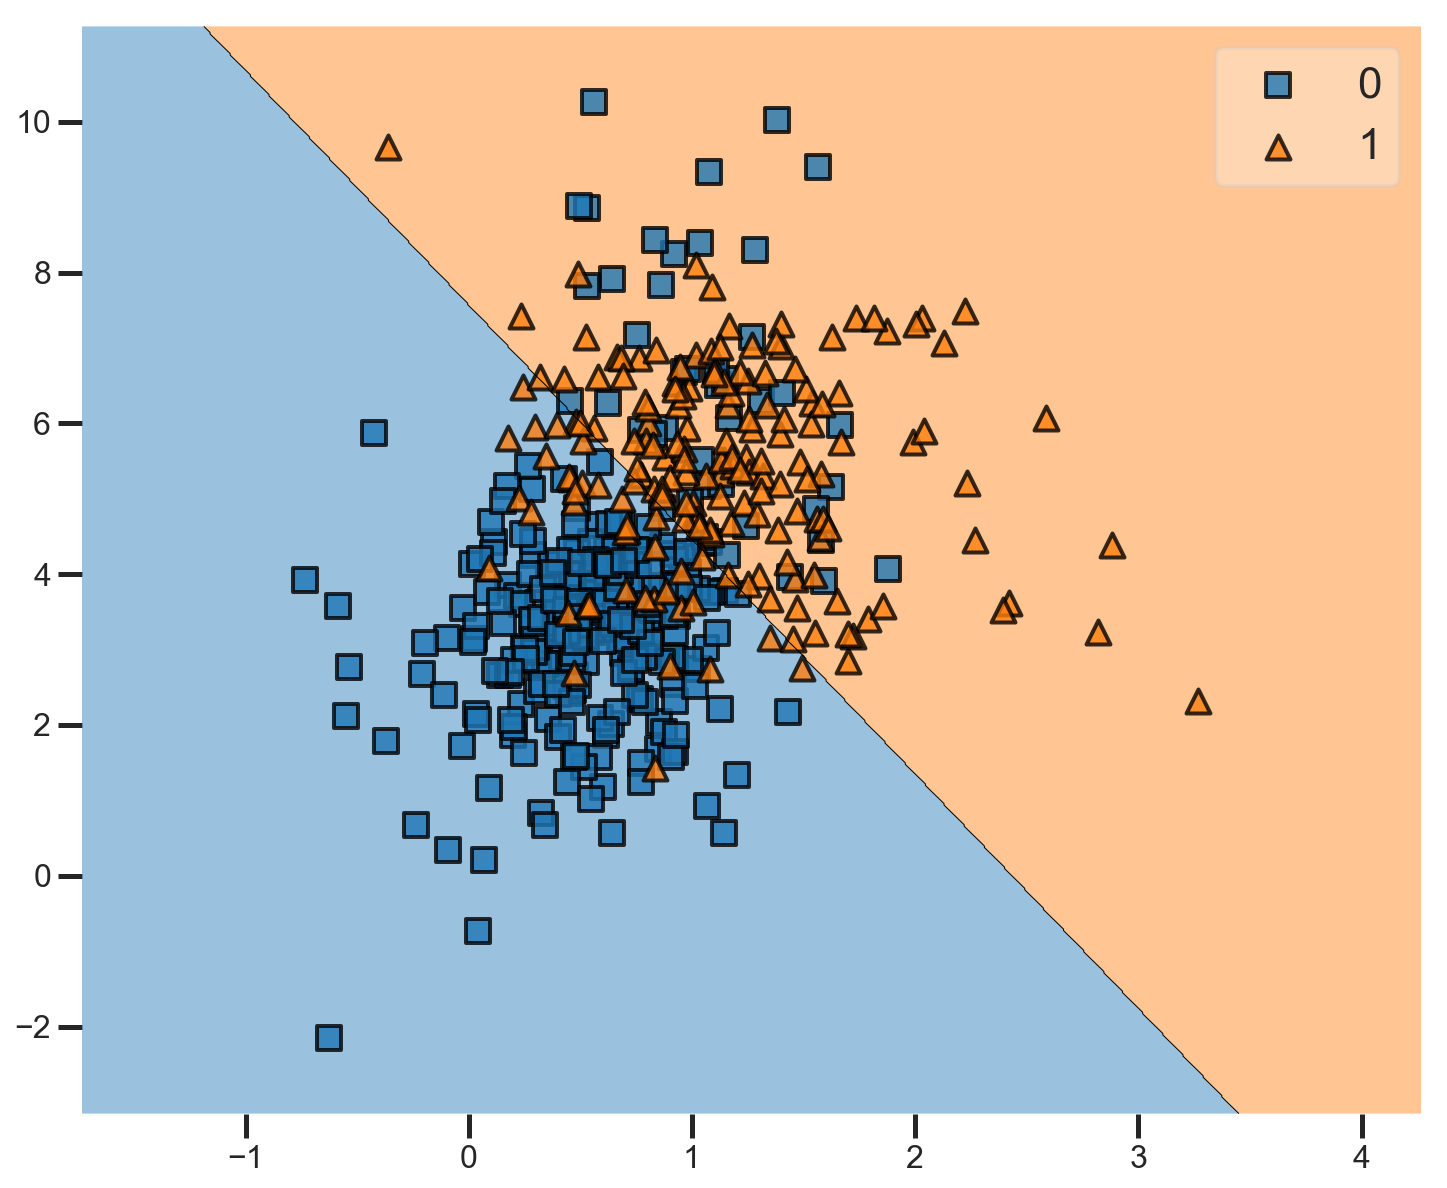

In [18]:
sns.set_style('white')
fig, ax = plt.subplots(1, 1, figsize = (12, 10))
plot_decision_regions(X = X_train, y = y_train.astype(np.integer), clf = clf_svm, ax = ax)

# PCA vs linear fit frame based

In [34]:
no_components = 2

accuracy_frame_comparison = np.zeros((no_cv, 4))
accuracy_roi_comparison = np.zeros((no_cv, 4))
for i in range(no_cv):
    testing_idx = [all_idx[i]]
    print(testing_idx)
    X_train, y_train = get_training_test_data_frame(dataBase, testing_idx, BSCs_dict, \
                                                    freq_bsc_dict, depth_dict, istrain = True, \
                                                    filter_depth=False, regression=False)
    X_test, y_test = get_training_test_data_frame(dataBase, testing_idx, BSCs_dict, \
                                                freq_bsc_dict, depth_dict, istrain = False, \
                                                filter_depth=False, regression=False)

    X_train, y_train, X_test, y_test, idxs1, idxs2 = randomize_and_filter(X_train.T, y_train, \
                                                                          X_test.T, y_test)   
    
    print("Training and testing shape", X_train.shape, X_test.shape)
    print('Labels shape', end = ': ')
    print(y_train.shape, y_test.shape)
   
    pca1 = PCA() ## PCA in the log10 of the BSCs.
    pca1.fit(np.log10(X_train))
    print("Explained variance", percentageVariance(pca1.explained_variance_, no_components))
    
    pca = PCA(n_components=no_components) ## PCA in the log10 of the BSCs.
    #pca = KernelPCA(n_components=3, kernel="rbf", degree = 4) #poly
    pca.fit(np.log10(X_train))
    features_train  = pca.transform(np.log10(X_train))
    features_test  = pca.transform(np.log10(X_test))
    print(features_test.shape, features_train.shape)
 
    clf = svm.SVC(C=10.0, kernel='linear', gamma=.1) #{'C': 10, 'gamma': 0.1}
    clf_linear = svm.SVC(C=10.0, kernel='linear', gamma=.1)
    
    linear_train = ESD_EAC_features(freq, X_train)
    linear_test = ESD_EAC_features(freq, X_test) 
    
    clf.fit(features_train, y_train)
    clf_linear.fit(linear_train, y_train)
    
    y_predict_linear = clf_linear.predict(linear_test)
    y_predict_pca = clf.predict(features_test)
    y_train_predict_pca = clf.predict(features_train)
    
    accuracy_roi_comparison[i, 0] = accuracy_score(y_test, y_predict_linear)
    print('Linear ROI testing accuracy:', accuracy_roi_comparison[i, 0])
    
    accuracy_roi_comparison[i, 1] = accuracy_score(y_test, y_predict_pca)
    print('PCA ROI testing accuracy:', accuracy_roi_comparison[i, 1])
    
    accuracy_roi_comparison[i, 2] = accuracy_score(y_train, clf_linear.predict(linear_train))
    print('Linear ROI Training accuracy:', accuracy_roi_comparison[i, 2])
    
    accuracy_roi_comparison[i, 3] = accuracy_score(y_train, y_train_predict_pca)
    print('PCA ROI Training accuracy:', accuracy_roi_comparison[i, 3])
    #break

[729]
Skip,749,750,752,730,739,751,754,753,740,731,755,757,756,758,729,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (552, 1024) (20, 1024)
Labels shape: (552,) (20,)
Explained variance 0.9723536706719045
(20, 2) (552, 2)
Linear ROI testing accuracy: 0.95
PCA ROI testing accuracy: 0.95
Linear ROI Training accuracy: 0.8804347826086957
PCA ROI Training accuracy: 0.8822463768115942
[749]
729,Skip,750,752,730,739,751,754,753,740,731,755,757,756,758,Skip,749,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (523, 1024) (49, 1024)
Labels shape: (523,) (49,)
Explained variance 0.972133548357543
(49, 2) (523, 2)
Linear ROI testing accuracy: 0.9387755102040817
PCA ROI testing accuracy: 0.9591836734693877
Linear ROI Training accuracy: 0.8795411089866156
PCA ROI Training accuracy: 0.8795411089866156
[750]
729,749,Skip,752,730,739,751,754,753,740,731,755,757,756,758,Skip,Skip,750,Skip,Skip,Skip,Skip,Skip,S

In [35]:
np.mean(accuracy_roi_comparison, axis = 0)

array([0.84108438, 0.82932546, 0.88423118, 0.88144708])

In [58]:
np.mean(accuracy_roi_comparison, axis = 0)

array([0.63588892, 0.62995551, 0.77099744, 0.77397023])

In [30]:
accuracy_roi_comparison

array([[0.93877551, 0.95918367, 0.87954111, 0.87954111],
       [1.        , 1.        , 0.87747748, 0.87567568],
       [0.63265306, 0.59183673, 0.9082218 , 0.89866157],
       [1.        , 1.        , 0.87453875, 0.87084871],
       [0.94      , 0.94      , 0.87164751, 0.8697318 ],
       [0.85714286, 0.75510204, 0.88527725, 0.87954111],
       [1.        , 1.        , 0.87613843, 0.87431694],
       [0.31578947, 0.28947368, 0.90449438, 0.90449438],
       [1.        , 1.        , 0.8728972 , 0.87102804],
       [0.76190476, 0.71428571, 0.88679245, 0.87735849],
       [0.22      , 0.24      , 0.92720307, 0.92720307],
       [1.        , 1.        , 0.87169811, 0.86603774],
       [1.        , 1.        , 0.87545788, 0.87912088],
       [1.        , 1.        , 0.87164751, 0.86590038],
       [0.        , 0.        , 0.        , 0.        ]])

# Combine BSCs and ATTs

In [36]:
from helper_brl.combineFeatures import combine_bscs_atts_frame, combine_pca_atts_frame, combine_pcas_atts

In [22]:
X_train, y_train = combine_pca_atts_frame(dataBase, testing_idx, freq, \
                                           BSCs_dict, ATTs_dict, pca, training = True)

NameError: name 'pca' is not defined

In [23]:
X_train.shape

(423, 4)

In [21]:
X_test, y_test = combine_bscs_atts_frame(dataBase, testing_idx, freq, \
                                         BSCs_dict, ATTs_dict, training = False)

In [22]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(404, 4) (50, 4) (404,) (50,)


In [37]:
all_idx = dataBase_filter.Rabbit.as_matrix()

In [39]:
lg_accuracy = np.zeros((14,4))
svm_accuracy = np.zeros((14,4))
#weights_lg = np.zeros((15, 4))
for i in range(no_cv-1):
    #testing_idx = all_idx[i*no_test_rabbits:i*no_test_rabbits+no_test_rabbits]
    testing_idx = [all_idx[i]]
    print(testing_idx, end = ', ')
    
    X_train, y_train = combine_bscs_atts_frame(dataBase_filter, testing_idx, freq, \
                                           BSCs_dict, ATTs_dict, training = True)
    X_test, y_test = combine_bscs_atts_frame(dataBase_filter, testing_idx, freq, \
                                         BSCs_dict, ATTs_dict, training = False)
    clf_lg = LogisticRegression(C = 1)
    clf_lg.fit(X_train,y_train)
    
    clf_svm = svm.SVC(C=1.0,kernel='linear', gamma=0.1)
    clf_svm.fit(X_train, y_train)
  
    y_predict_lg = clf_lg.predict(X_test)
    y_predict_svm = clf_svm.predict(X_test)
    
    lg_accuracy[i, 0] = accuracy_score(y_test, y_predict_lg)
    lg_accuracy[i, 1] = accuracy_score(y_train, clf_lg.predict(X_train))
    
    svm_accuracy[i, 0] = accuracy_score(y_test, y_predict_svm)
    svm_accuracy[i, 1] = accuracy_score(y_train, clf_svm.predict(X_train))

[749], [750], [752], [730], [739], [751], [754], [753], [740], [731], [755], [757], [756], [758], 

In [40]:
print(np.mean(lg_accuracy, axis = 0))
print(np.mean(svm_accuracy, axis = 0))

[0.93376783 0.94662407 0.         0.        ]
[0.89918994 0.95019258 0.         0.        ]


In [41]:
print(np.mean(lg_accuracy, axis = 0))
print(np.mean(svm_accuracy, axis = 0))

[0.77010162 0.85176493 0.         0.        ]
[0.74093165 0.86473441 0.         0.        ]


In [33]:
print(np.mean(lg_accuracy, axis = 0))
print(np.mean(svm_accuracy, axis = 0))

[0.77568892 0.85164798 0.         0.        ]
[0.73959832 0.86378965 0.         0.        ]


# PCA + ATT frame

In [41]:
from sklearn.linear_model import LogisticRegression

In [43]:
no_components = 2

accuracy_frame_comparison = np.zeros((no_cv-1, 4))
accuracy_roi_comparison = np.zeros((no_cv-1, 4))
for i in range(no_cv-1):
    testing_idx = [all_idx[i]]
    print(testing_idx)
    X_train, y_train = get_training_test_data_frame(dataBase_filter, testing_idx, BSCs_dict, \
                                                    freq_bsc_dict, depth_dict, istrain = True, \
                                                    filter_depth=False, regression=False)
    X_test, y_test = get_training_test_data_frame(dataBase_filter, testing_idx, BSCs_dict, \
                                                freq_bsc_dict, depth_dict, istrain = False, \
                                                filter_depth=False, regression=False)

    X_train, y_train, X_test, y_test, idxs1, idxs2 = randomize_and_filter(X_train.T, y_train, \
                                                                          X_test.T, y_test)   
    
    print("Training and testing shape", X_train.shape, X_test.shape)
    print('Labels shape', end = ': ')
    print(y_train.shape, y_test.shape)
    
    pca = PCA(n_components=no_components) ## PCA in the log10 of the BSCs.
    pca.fit(np.log10(X_train))
    
      
    features_train, y_train = combine_pca_atts_frame(dataBase_filter, testing_idx, freq, \
                                           BSCs_dict, ATTs_dict, pca, training = True)
    features_test, y_test = combine_pca_atts_frame(dataBase_filter, testing_idx, freq, \
                                           BSCs_dict, ATTs_dict, pca, training = False)
    
    print(features_train.shape, features_test.shape, y_train.shape, y_test.shape)
    #break
    #clf = svm.SVC(C=10.0, kernel='linear', gamma=.1) #{'C': 10, 'gamma': 0.1}
    clf_lg = LogisticRegression()
    #clf_lg.fit(X_train[:,2:],y_train)
    #clf_linear = svm.SVC(C=10.0, kernel='linear', gamma=.1)
    
    clf_lg.fit(features_train, y_train)
    #clf_linear.fit(linear_train, y_train)
    
    #y_predict_linear = clf_linear.predict(linear_test)
    y_predict_pca = clf_lg.predict(features_test)
    y_train_predict_pca = clf_lg.predict(features_train)
 
    accuracy_roi_comparison[i, 1] = accuracy_score(y_test, y_predict_pca)
    print('PCA ROI testing accuracy:', accuracy_roi_comparison[i, 1])
  
    accuracy_roi_comparison[i, 3] = accuracy_score(y_train, y_train_predict_pca)
    print('PCA ROI Training accuracy:', accuracy_roi_comparison[i, 3])
    #break

[749]
Skip,750,752,730,739,751,754,753,740,731,755,757,756,758,749,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (503, 1024) (49, 1024)
Labels shape: (503,) (49,)
(361, 4) (49, 4) (361,) (49,)
PCA ROI testing accuracy: 1.0
PCA ROI Training accuracy: 0.9224376731301939
[750]
749,Skip,752,730,739,751,754,753,740,731,755,757,756,758,Skip,750,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (535, 1024) (17, 1024)
Labels shape: (535,) (17,)
(394, 4) (16, 4) (394,) (16,)
PCA ROI testing accuracy: 1.0
PCA ROI Training accuracy: 0.9263959390862944
[752]
749,750,Skip,730,739,751,754,753,740,731,755,757,756,758,Skip,Skip,752,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (503, 1024) (49, 1024)
Labels shape: (503,) (49,)
(361, 4) (49, 4) (361,) (49,)
PCA ROI testing accuracy: 0.7142857142857143
PCA ROI Training accuracy: 0.9445983379501385
[730]
749,750,752,Skip,739,751,754,753,7

In [44]:
np.mean(accuracy_roi_comparison, axis = 0)

array([0.        , 0.88667764, 0.        , 0.93146552])

In [112]:
np.mean(accuracy_roi_comparison, axis = 0)

array([0.        , 0.67953327, 0.        , 0.85257728])

In [93]:
pca.transform(np.log10(X_test[33,:]).reshape(1,-1)).shape

(1, 2)

# PCA + ATT block

In [45]:
no_components = 2

accuracy_frame_comparison = np.zeros((no_cv-1, 4))
accuracy_roi_comparison = np.zeros((no_cv-1, 4))
for i in range(no_cv-1):
    testing_idx = [all_idx[i]]
    print(testing_idx)
    X_train, y_train = get_training_test_data_frame(dataBase_filter, testing_idx, BSCs_dict, \
                                                    freq_bsc_dict, depth_dict, istrain = True, \
                                                    filter_depth=False, regression=False)
    X_test, y_test = get_training_test_data_frame(dataBase_filter, testing_idx, BSCs_dict, \
                                                freq_bsc_dict, depth_dict, istrain = False, \
                                                filter_depth=False, regression=False)

    X_train, y_train, X_test, y_test, idxs1, idxs2 = randomize_and_filter(X_train.T, y_train, \
                                                                          X_test.T, y_test)   
    
    print("Training and testing shape", X_train.shape, X_test.shape)
    print('Labels shape', end = ': ')
    print(y_train.shape, y_test.shape)
    
    pca = PCA(n_components=no_components) ## PCA in the log10 of the BSCs.
    pca.fit(np.log10(X_train))
    
    features_train, y_train = combine_pcas_atts(dataBase_filter, testing_idx, freq, \
                                           BSCs_dict, ATTs_dict, pca, training = True)
    features_test, y_test = combine_pcas_atts(dataBase_filter, testing_idx, freq, \
                                           BSCs_dict, ATTs_dict, pca, training = False)
    
    print(features_train.shape, features_test.shape, y_train.shape, y_test.shape)
    #break
    clf = LogisticRegression()
    #clf = svm.SVC(C=1.0, kernel='linear', gamma=.1) #{'C': 10, 'gamma': 0.1}
    #clf_linear = svm.SVC(C=10.0, kernel='linear', gamma=.1)
    
    clf.fit(features_train, y_train)
    #clf_linear.fit(linear_train, y_train)
    
    #y_predict_linear = clf_linear.predict(linear_test)
    y_predict_pca = clf.predict(features_test)
    y_train_predict_pca = clf.predict(features_train)
 
    accuracy_roi_comparison[i, 1] = accuracy_score(y_test, y_predict_pca)
    print('PCA ROI testing accuracy:', accuracy_roi_comparison[i, 1])
  
    accuracy_roi_comparison[i, 3] = accuracy_score(y_train, y_train_predict_pca)
    print('PCA ROI Training accuracy:', accuracy_roi_comparison[i, 3])
    #break

[749]
Skip,750,752,730,739,751,754,753,740,731,755,757,756,758,749,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (503, 1024) (49, 1024)
Labels shape: (503,) (49,)
(1446, 4) (292, 4) (1446,) (292,)
PCA ROI testing accuracy: 0.9657534246575342
PCA ROI Training accuracy: 0.9059474412171508
[750]
749,Skip,752,730,739,751,754,753,740,731,755,757,756,758,Skip,750,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (535, 1024) (17, 1024)
Labels shape: (535,) (17,)
(1709, 4) (29, 4) (1709,) (29,)
PCA ROI testing accuracy: 1.0
PCA ROI Training accuracy: 0.9174956114686952
[752]
749,750,Skip,730,739,751,754,753,740,731,755,757,756,758,Skip,Skip,752,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (503, 1024) (49, 1024)
Labels shape: (503,) (49,)
(1527, 4) (211, 4) (1527,) (211,)
PCA ROI testing accuracy: 0.8151658767772512
PCA ROI Training accuracy: 0.9220694171578258
[730]
749,750,7

In [46]:
np.mean(accuracy_roi_comparison, axis = 0)

array([0.       , 0.853203 , 0.       , 0.9193881])

# PCA visualization

In [120]:
no_components = 4
testing_idx = [729]
X_train, y_train = get_training_test_data_frame(dataBase, testing_idx, BSCs_dict, \
                                                freq_bsc_dict, depth_dict, istrain = True, \
                                                filter_depth=False, regression=False)
X_test, y_test = get_training_test_data_frame(dataBase, testing_idx, BSCs_dict, \
                                            freq_bsc_dict, depth_dict, istrain = False, \
                                            filter_depth=False, regression=False)

#X_train, y_train, X_test, y_test, idxs1, idxs2 = randomize_and_filter(X_train, y_train, \
#                                                                          X_test, y_test) 
print(X_train.shape, X_test.shape)

X_all = np.vstack((X_train, X_test))

pca = PCA(n_components=no_components) ## PCA in the log10 of the BSCs.
pca.fit(np.log10(X_all))

features_all = pca.transform(np.log10(X_all))
print(features_all.shape)

Skip,749,750,752,730,739,751,754,753,740,731,755,757,756,758,729,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,(529, 1024) (37, 1024)
(566, 4)


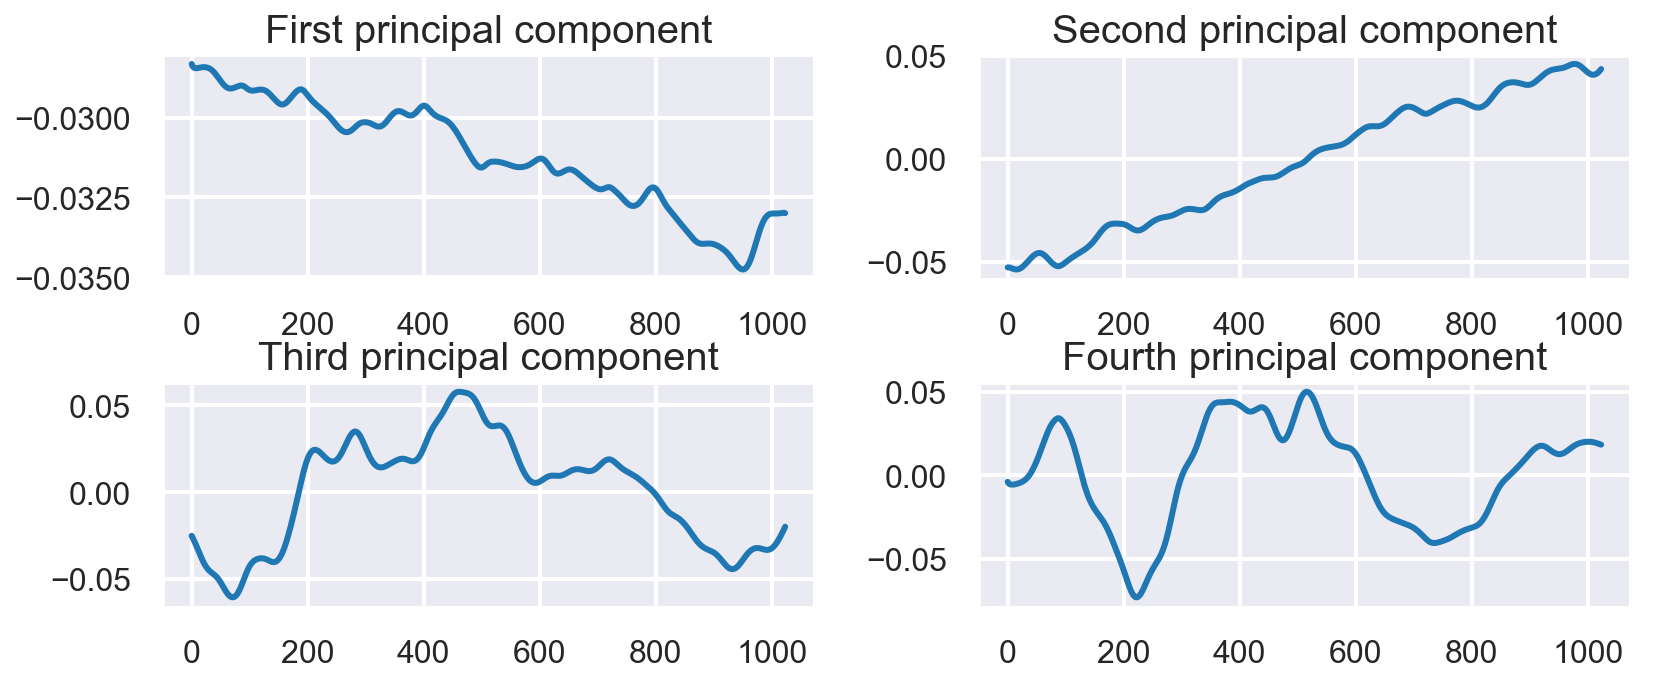

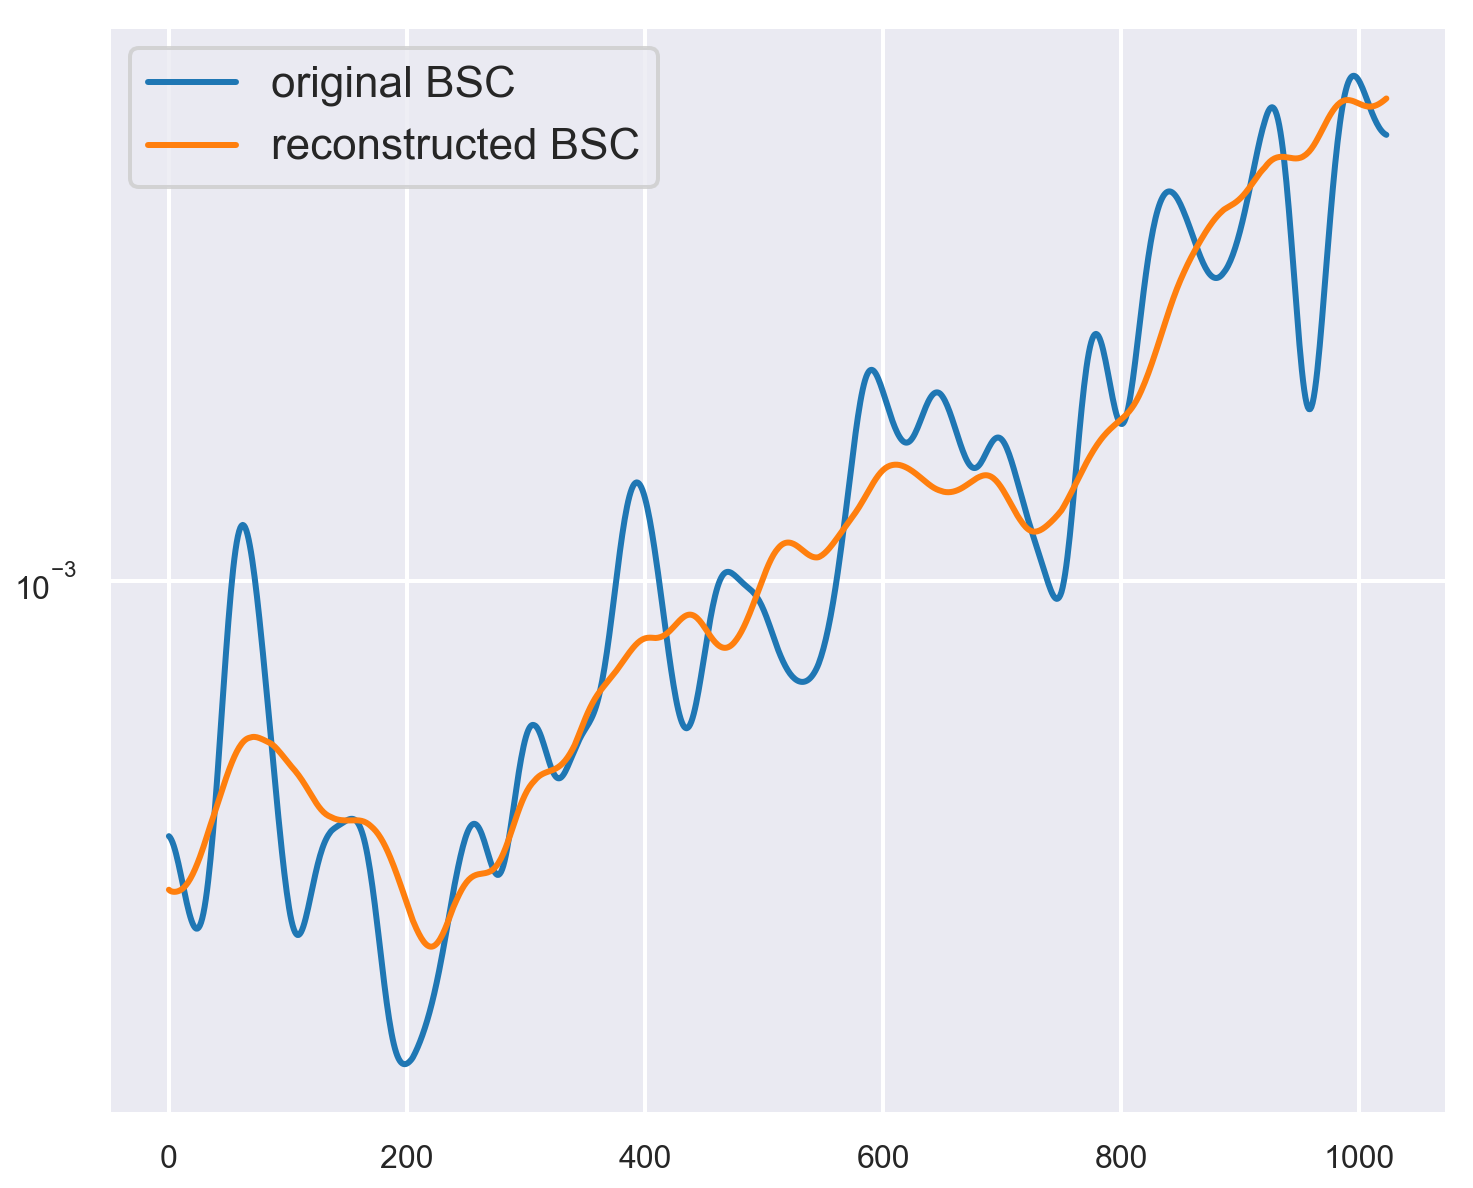

In [129]:
plt.figure(figsize = (12, 10))
plt.subplot(4,2, 1)
plt.plot(pca.components_[0])
plt.title("First principal component")
plt.subplot(4,2, 2)
plt.plot(pca.components_[1])
plt.title("Second principal component")

plt.subplot(4,2, 3)
plt.plot(pca.components_[2])
plt.title("Third principal component")

plt.subplot(4,2, 4)
plt.plot(pca.components_[3])
plt.title("Fourth principal component")
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.45,
                    wspace=0.25)
plt.figure(figsize = (12, 10))
idx = 233
plt.semilogy((X_all[idx,:]), label = 'original BSC')
plt.semilogy(10**(pca.inverse_transform(features_all[idx,:])), label = 'reconstructed BSC')
plt.legend()
#plt.yscale('log')

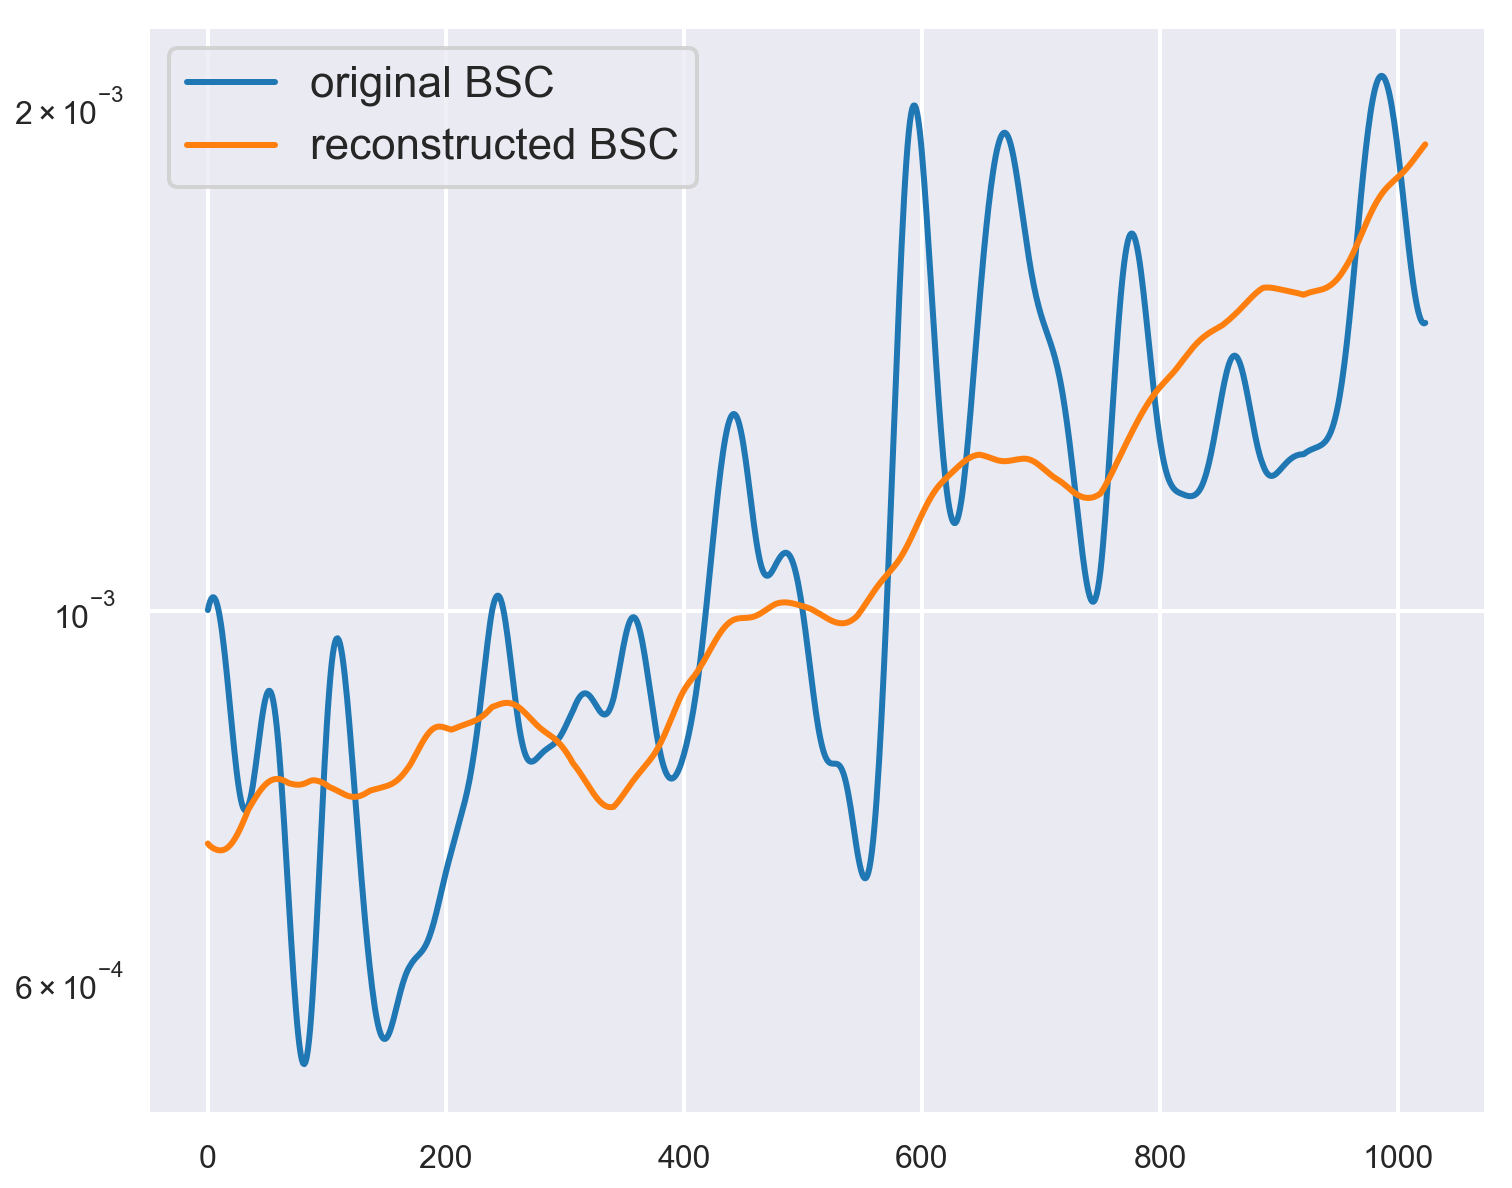

In [119]:
plt.figure(figsize = (12, 10))
idx = 400
plt.semilogy((X_all[idx,:]), label = 'original BSC')
plt.semilogy(10**(pca.inverse_transform(features_all[idx,:])), label = 'reconstructed BSC')
plt.legend()

Skip,749,750,752,730,739,751,754,753,740,731,755,757,756,758,729,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (529, 1024) (37, 1024)
Labels shape: (529,) (37,)
729,Skip,750,752,730,739,751,754,753,740,731,755,757,756,758,Skip,749,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (517, 1024) (49, 1024)
Labels shape: (517,) (49,)
729,749,Skip,752,730,739,751,754,753,740,731,755,757,756,758,Skip,Skip,750,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (549, 1024) (17, 1024)
Labels shape: (549,) (17,)
729,749,750,Skip,730,739,751,754,753,740,731,755,757,756,758,Skip,Skip,Skip,752,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (517, 1024) (49, 1024)
Labels shape: (517,) (49,)
729,749,750,752,Skip,739,751,754,753,740,731,755,757,756,758,Skip,Skip,Skip,Skip,730,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and test

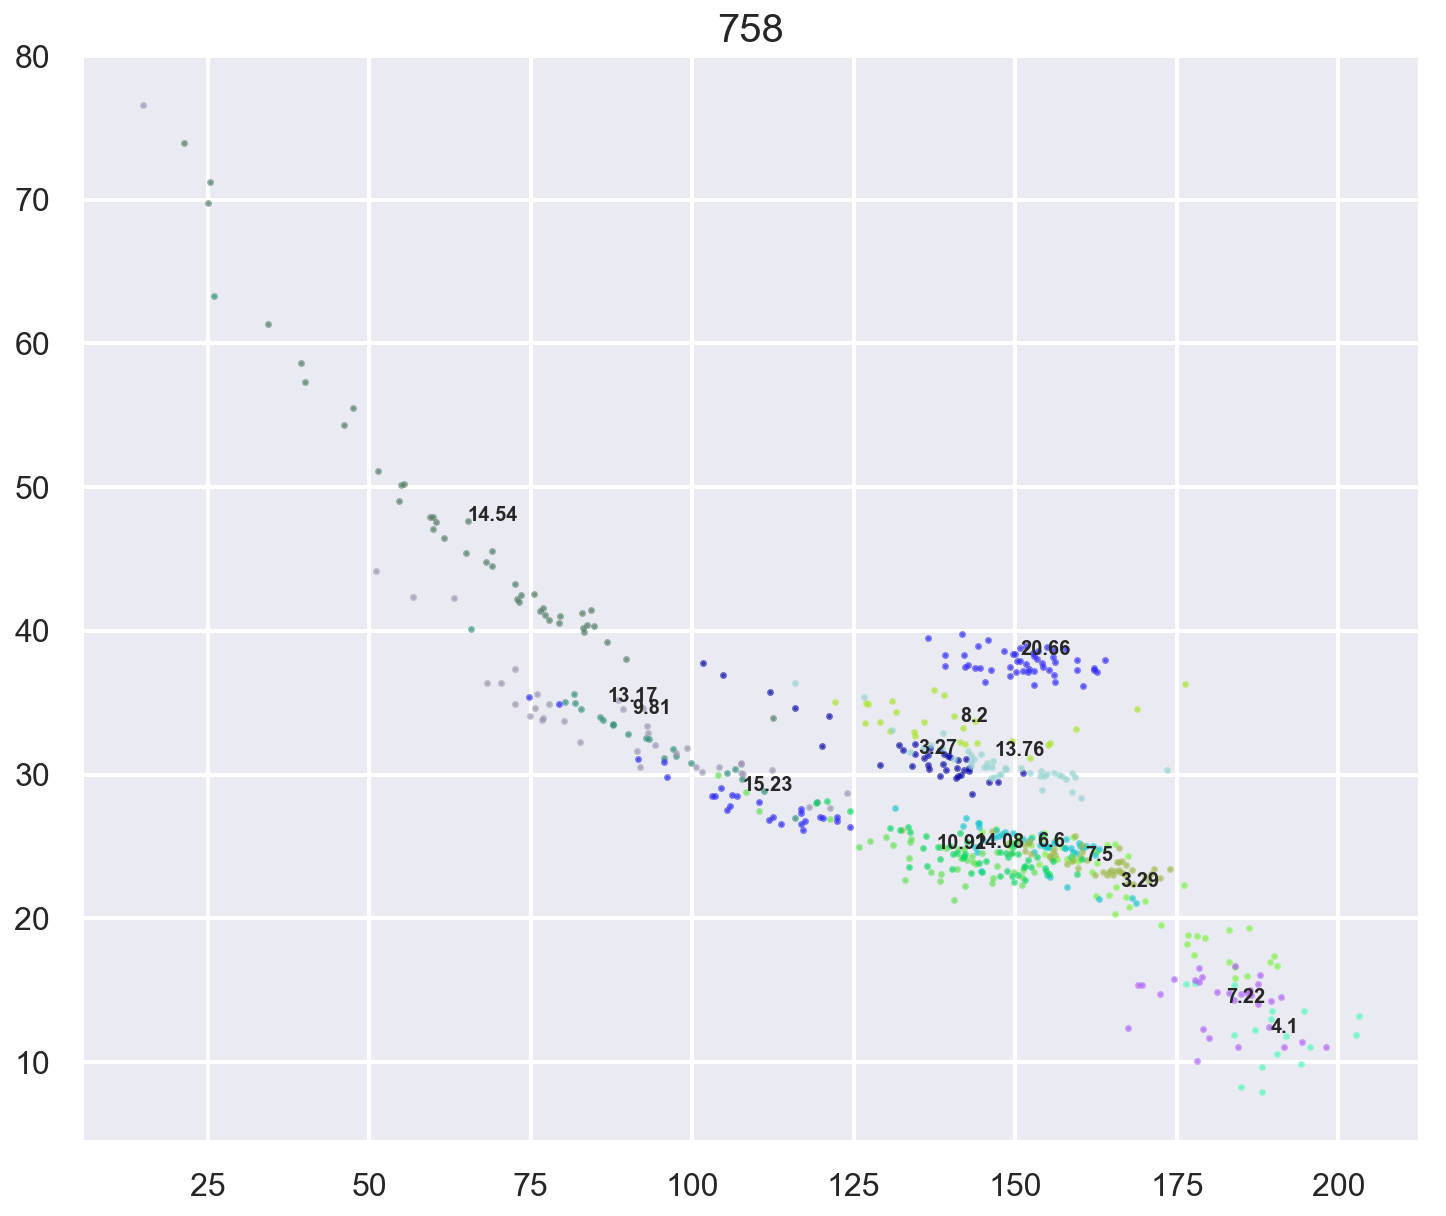

In [26]:
plt.figure(figsize = (12, 10))
for idx, row in dataBase.iterrows():
    number = (int(row.Rabbit))  
    lipid  = str(row.Lipid)
    testing_idx = [number]
    X_train, y_train = get_training_test_data_frame(dataBase, testing_idx, BSCs_dict, \
                                                freq_bsc_dict, depth_dict, istrain = True, \
                                                filter_depth=False, regression=False)
    X_test, y_test = get_training_test_data_frame(dataBase, testing_idx, BSCs_dict, \
                                                freq_bsc_dict, depth_dict, istrain = False, \
                                                filter_depth=False, regression=False) 
    print("Training and testing shape", X_train.shape, X_test.shape)
    print('Labels shape', end = ': ')
    print(y_train.shape, y_test.shape)

    #linear_train = ESD_EAC_features(freq, X_train)
    features_test = ESD_EAC_features(freq, X_test) 

    l1 = np.where(y_train == 0)[0]
    l2 = np.where(y_train == 1)[0]
    l3 = np.where(y_test == 0) [0]
    l4 = np.where(y_test == 1) [0]
   
    plt.scatter(features_test[l3, 0], features_test[l3, 1], c =np.random.rand(3,), s = 2, alpha = 0.6)
   
    if l3.size > 0:
        plt.text(features_test[l3, 0].mean(), features_test[l3, 1].mean(), lipid, fontweight='bold', fontsize = 10)
    if l4.size > 0:
        plt.text(features_test[l4, 0].mean()-0.5, features_test[l4, 1].mean()+0.5, lipid, fontweight = 'bold', fontsize = 10)

    plt.scatter(features_test[l4, 0], features_test[l4, 1], c = np.random.rand(3,), s = 2, alpha = 0.6)
    plt.title(str(testing_idx[0]))

Skip,749,750,752,730,739,751,754,753,740,731,755,757,756,758,729,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (529, 1024) (37, 1024)
Labels shape: (529,) (37,)
729,Skip,750,752,730,739,751,754,753,740,731,755,757,756,758,Skip,749,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (517, 1024) (49, 1024)
Labels shape: (517,) (49,)
729,749,Skip,752,730,739,751,754,753,740,731,755,757,756,758,Skip,Skip,750,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (549, 1024) (17, 1024)
Labels shape: (549,) (17,)
729,749,750,Skip,730,739,751,754,753,740,731,755,757,756,758,Skip,Skip,Skip,752,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (517, 1024) (49, 1024)
Labels shape: (517,) (49,)
729,749,750,752,Skip,739,751,754,753,740,731,755,757,756,758,Skip,Skip,Skip,Skip,730,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and test

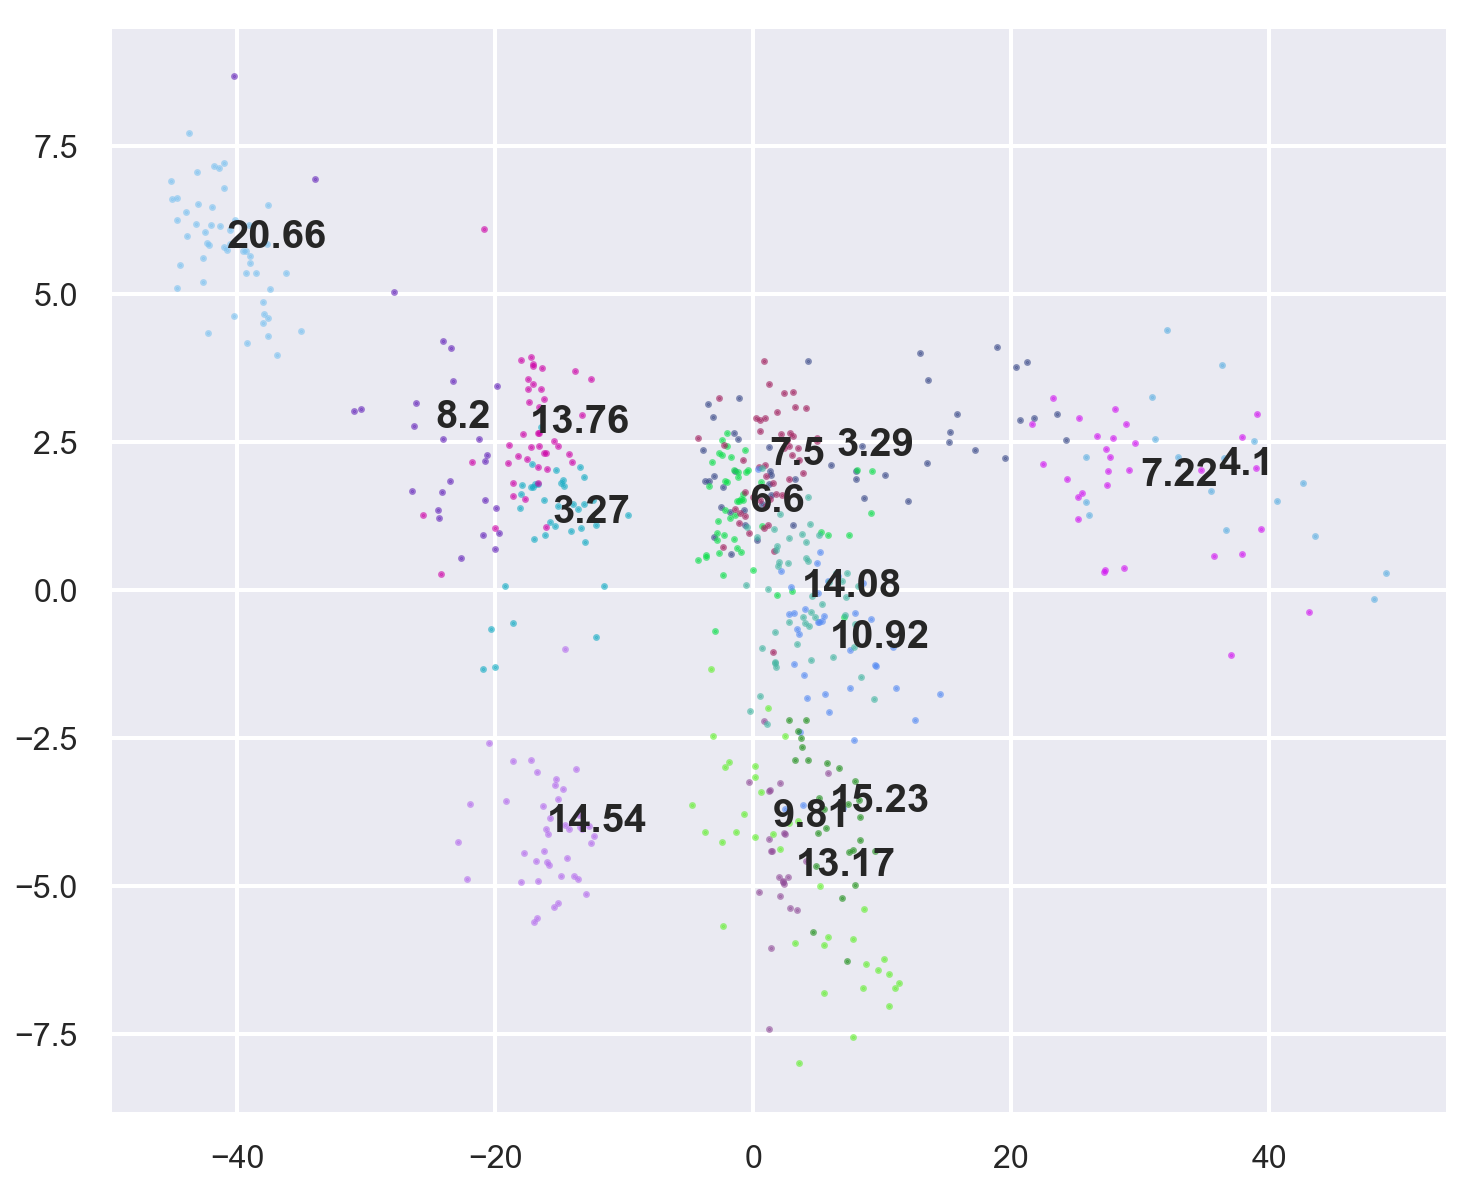

In [27]:
plt.figure(figsize = (12, 10))
for idx, row in dataBase.iterrows():
    number = (int(row.Rabbit))  
    lipid  = str(row.Lipid)
    testing_idx = [number]
    X_train, y_train = get_training_test_data_frame(dataBase, testing_idx, BSCs_dict, \
                                                freq_bsc_dict, depth_dict, istrain = True, \
                                                filter_depth=False, regression=False)
    X_test, y_test = get_training_test_data_frame(dataBase, testing_idx, BSCs_dict, \
                                                freq_bsc_dict, depth_dict, istrain = False, \
                                                filter_depth=False, regression=False) 
    print("Training and testing shape", X_train.shape, X_test.shape)
    print('Labels shape', end = ': ')
    print(y_train.shape, y_test.shape)

    features_test  = pca.transform(np.log10(X_test))

    l1 = np.where(y_train == 0)[0]
    l2 = np.where(y_train == 1)[0]
    l3 = np.where(y_test == 0) [0]
    l4 = np.where(y_test == 1) [0]
   
    plt.scatter(features_test[l3, 0], features_test[l3, 1], c =np.random.rand(3,), s = 2, alpha = 0.6)
    if number == 754:
        if l3.size > 0:
            plt.text(features_test[l3, 0].mean(), features_test[l3, 1].mean(), lipid, fontweight='bold')
        if l4.size > 0:
            plt.text(features_test[l4, 0].mean()-0.5, features_test[l4, 1].mean()+0.5, lipid, fontweight = 'bold')
    else:
        if l3.size > 0:
            plt.text(features_test[l3, 0].mean(), features_test[l3, 1].mean(), lipid, fontweight='bold')
        if l4.size > 0:
            plt.text(features_test[l4, 0].mean(), features_test[l4, 1].mean(), lipid, fontweight = 'bold')
    plt.scatter(features_test[l4, 0], features_test[l4, 1], c = np.random.rand(3,), s = 2, alpha = 0.6)
   

# Kernel PCA

In [28]:
from sklearn.decomposition import KernelPCA

In [41]:
no_components = 5
testing_idx = [729]
X_train, y_train = get_training_test_data_frame(dataBase, testing_idx, BSCs_dict, \
                                                freq_bsc_dict, depth_dict, istrain = True, \
                                                filter_depth=False, regression=False)
X_test, y_test = get_training_test_data_frame(dataBase, testing_idx, BSCs_dict, \
                                            freq_bsc_dict, depth_dict, istrain = False, \
                                            filter_depth=False, regression=False)

#X_train, y_train, X_test, y_test, idxs1, idxs2 = randomize_and_filter(X_train, y_train, \
#                                                                          X_test, y_test) 
print(X_train.shape, X_test.shape)

X_all = np.vstack((X_train, X_test))

kpca = KernelPCA(n_components=2, kernel="cosine", degree = 5) ## PCA in the log10 of the BSCs.
kpca.fit(np.log10(X_all))

Skip,749,750,752,730,739,751,754,753,740,731,755,757,756,758,729,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,(529, 1024) (37, 1024)


KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=5, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='cosine',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)

Skip,749,750,752,730,739,751,754,753,740,731,755,757,756,758,729,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (529, 1024) (37, 1024)
Labels shape: (529,) (37,)
729,Skip,750,752,730,739,751,754,753,740,731,755,757,756,758,Skip,749,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (517, 1024) (49, 1024)
Labels shape: (517,) (49,)
729,749,Skip,752,730,739,751,754,753,740,731,755,757,756,758,Skip,Skip,750,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (549, 1024) (17, 1024)
Labels shape: (549,) (17,)
729,749,750,Skip,730,739,751,754,753,740,731,755,757,756,758,Skip,Skip,Skip,752,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and testing shape (517, 1024) (49, 1024)
Labels shape: (517,) (49,)
729,749,750,752,Skip,739,751,754,753,740,731,755,757,756,758,Skip,Skip,Skip,Skip,730,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Skip,Training and test

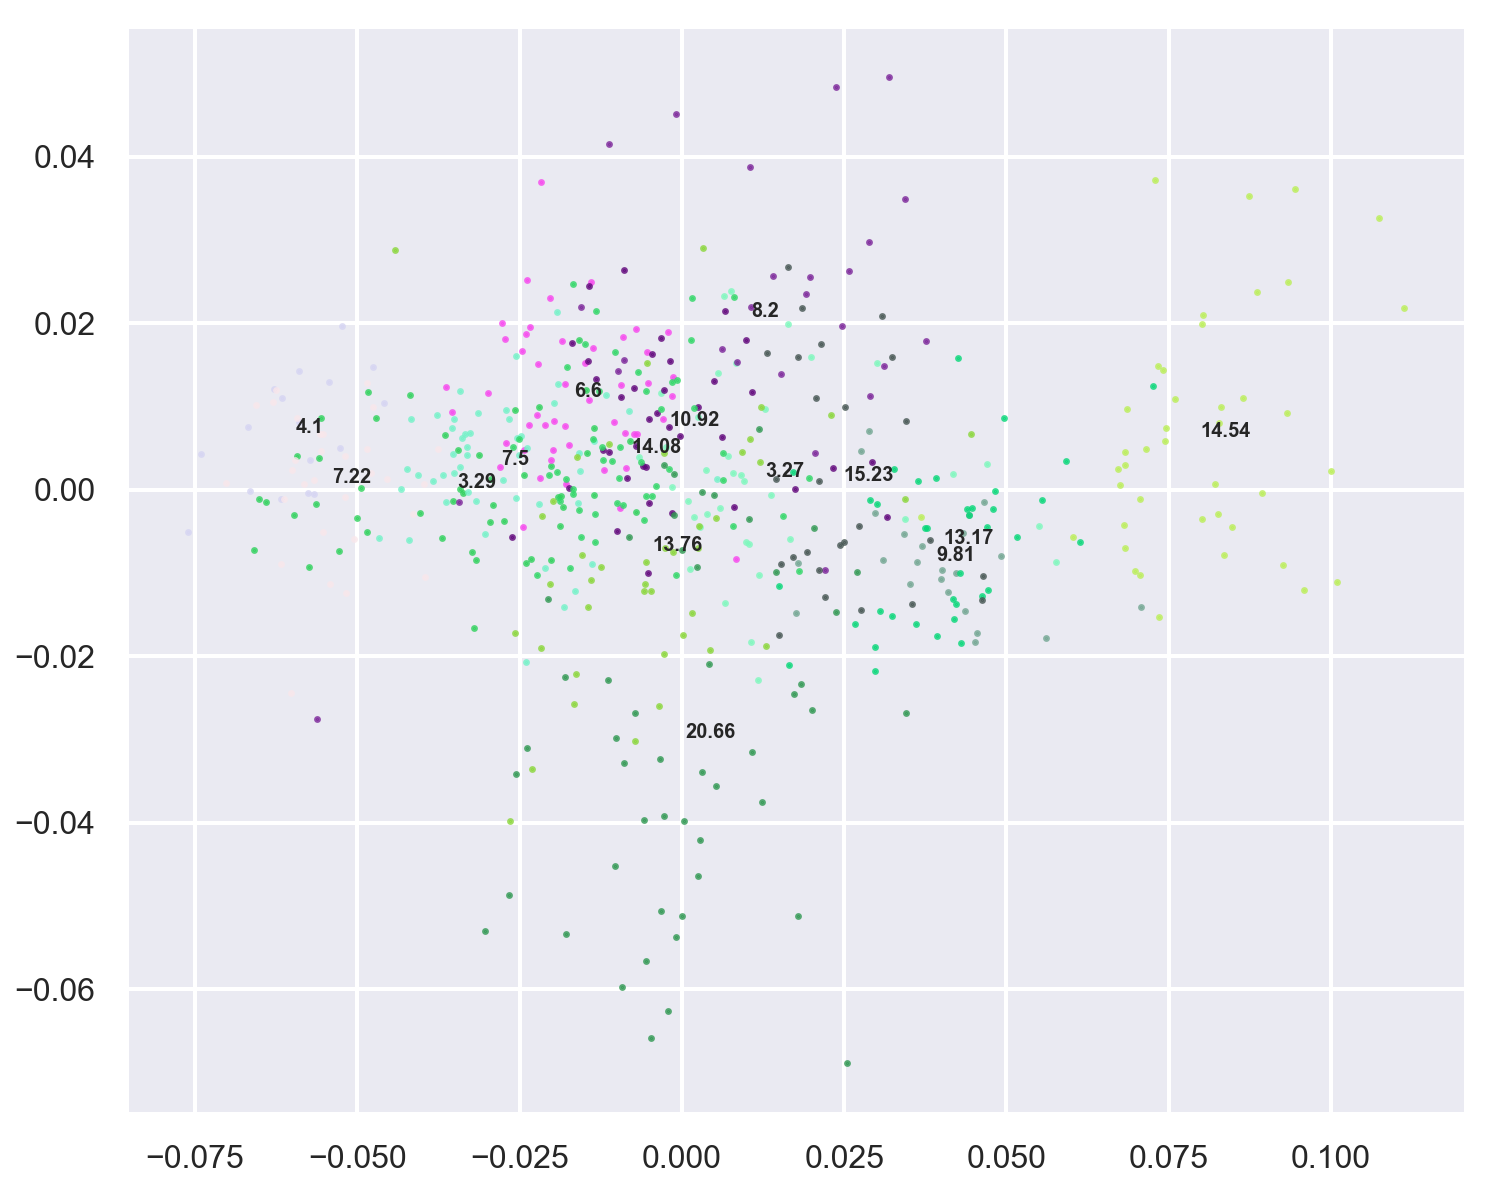

In [42]:
plt.figure(figsize = (12, 10))
for idx, row in dataBase.iterrows():
    number = (int(row.Rabbit))  
    lipid  = str(row.Lipid)
    testing_idx = [number]
    X_train, y_train = get_training_test_data_frame(dataBase, testing_idx, BSCs_dict, \
                                                freq_bsc_dict, depth_dict, istrain = True, \
                                                filter_depth=False, regression=False)
    X_test, y_test = get_training_test_data_frame(dataBase, testing_idx, BSCs_dict, \
                                                freq_bsc_dict, depth_dict, istrain = False, \
                                                filter_depth=False, regression=False) 
    print("Training and testing shape", X_train.shape, X_test.shape)
    print('Labels shape', end = ': ')
    print(y_train.shape, y_test.shape)

    features_test  = kpca.transform(np.log10(X_test))

    l1 = np.where(y_train == 0)[0]
    l2 = np.where(y_train == 1)[0]
    l3 = np.where(y_test == 0) [0]
    l4 = np.where(y_test == 1) [0]
   
    plt.scatter(features_test[l3, 0], features_test[l3, 1], c =np.random.rand(3,), s = 2, alpha = 0.8)

    if l3.size > 0:
        plt.text(features_test[l3, 0].mean(), features_test[l3, 1].mean(), lipid, fontweight='bold', fontsize =10)
    if l4.size > 0:
        plt.text(features_test[l4, 0].mean(), features_test[l4, 1].mean(), lipid, fontweight = 'bold', fontsize = 10)
    plt.scatter(features_test[l4, 0], features_test[l4, 1], c = np.random.rand(3,), s = 2, alpha = 0.8)
   